## Import

In [1]:
import numpy as np
import pandas as pd


from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.feature_selection import SelectKBest,VarianceThreshold
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin



import matplotlib.pyplot as plt

## Load and Clean Data

In [2]:
#load data
df_dict = pd.read_excel('dataset.xlsx',sheet_name=None)
df = df_dict["Training"]

remove_outliers = True
normalization = False

tmp_df = df.copy()
if remove_outliers:
    #tmp_df = tmp_df[tmp_df.iloc[:,1:].mean(axis=1) > 0.8]
    tmp_df = tmp_df[tmp_df['col1'] >= 1]
    


#shuffle
tmp_df = tmp_df.sample(frac=1,random_state=0).reset_index(drop=True)

X = tmp_df.iloc[:,1:].values
Y = tmp_df["Diet"].values

if normalization:
    X = X.sub(X.mean(1), axis=0).div(X.std(1), axis=0)

## Random Polynomial Transformer

In [3]:
#https://stackoverflow.com/questions/6881170/is-there-a-way-to-autogenerate-valid-arithmetic-expressions
def generateExpression(minTerminal, maxTerminal, maxdepth, group_prob = 0.5, depth=0):
    
    GROUP_PROB = group_prob
    expr = ""
    CONST_PROB = 0.0 # it seems const doesn't help
    UNARY_PROB = 0.0 # it seems unary doesn't help
    
    if np.random.uniform() < UNARY_PROB:
        return np.random.choice(["np.cos","np.exp"]) + "(" + f'X[:,{np.random.randint(minTerminal, maxTerminal)}]' + ")"
    
    grouped = np.random.uniform()< GROUP_PROB    
    if grouped:
        expr += '('
    
    if depth < maxdepth and np.random.randint(0, maxdepth) > depth:
        expr += generateExpression(minTerminal, maxTerminal, maxdepth, group_prob=group_prob, depth=depth + 1)
    else:
        if np.random.uniform() < CONST_PROB:
            expr += f'{np.random.uniform()}'
        else:
            expr += f'X[:,{np.random.randint(minTerminal, maxTerminal)}]'
    
    expr += np.random.choice([" * ", " - ", " + "])
    
    if depth < maxdepth and np.random.randint(0, maxdepth) > depth:
        expr += generateExpression(minTerminal, maxTerminal, maxdepth, group_prob=group_prob, depth=depth + 1)
    else:
        if np.random.uniform() < CONST_PROB:
            expr += f'{np.random.uniform()}'
        else:
            expr += f'X[:,{np.random.randint(minTerminal, maxTerminal)}]'
    
    if grouped:
        expr += ')'
    return expr

class RandomPolynomialTransformer(BaseEstimator, TransformerMixin):            
    
    def __init__(self, num_kernels=100, random_state=42, keep_origin=False, group_prob=0.5): 
        self.num_kernels = num_kernels
        self.random_state = random_state
        self.keep_origin = keep_origin
        self.group_prob = group_prob
        
            
    def fit(self, X, y = None):   
        np.random.seed(self.random_state)
        input_length = X.shape[1]
        self.kernels = []   
        
        for i in range(self.num_kernels):
            
            kernel = generateExpression(0, input_length, 3, group_prob = self.group_prob) 
            
            self.kernels.append(kernel)
            
        return self    
    
    def transform(self, X, y = None):                
        X_transform = np.zeros((X.shape[0],self.num_kernels))
        for i in range(self.num_kernels):           
            X_transform[:,i] = eval(self.kernels[i])
            
        if self.keep_origin:
            return np.hstack((X_transform,X))
        else:
            return X_transform

class RocketNormalizer(BaseEstimator, TransformerMixin):            
            
    def fit(self, X, y = None):        
        self._mean = X.mean(0)
        self._norm = np.sqrt(np.square(X - self._mean).sum(axis=0)) + 1e-8        
        return self    
    
    def transform(self, X, y = None):                
        return (X - self._mean) / self._norm
    
def test_clf(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
    disp.plot()
    plt.show()

def mean_acc_cv(clf,X,Y,cv=3):
    #print(f'---- Cross Validation ----')
    scores = cross_validate(clf, X, Y, scoring="accuracy", cv=cv)
    print(f"CV Mean Accuracy={cv}: {np.mean(scores['test_score'])}")    

def single_split_experiment_old(clf, X, Y):   
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
    print('----- Whole Series -----')
    
    test_clf(clf, X_train, X_test, y_train, y_test)
    
    intervals = [(0,172),(206,306),(729,748)] #some how this produced better results
    for itv_start, itv_end in intervals:        
        print(f'----- Interval: {itv_start} - {itv_end} -----')        
        test_clf(clf, X_train[:,itv_start:itv_end], X_test[:,itv_start:itv_end], y_train, y_test)
    
    print('----- Interval: 0-172 206-306 -----')
    X_train_no_water = X_train[:, np.r_[0:172, 206:306]]
    X_test_no_water = X_test[:, np.r_[0:172, 206:306]]
    test_clf(clf, X_train_no_water, X_test_no_water, y_train, y_test)
    
    print('----- No Water -----')
    X_train_no_water = X_train[:, np.r_[0:172, 206:306, 729:748]]
    X_test_no_water = X_test[:, np.r_[0:172, 206:306, 729:748]]
    test_clf(clf, X_train_no_water, X_test_no_water, y_train, y_test)
    
def single_split_experiment(clf, X, Y):    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
    print('----- Whole Series -----')
    
    test_clf(clf, X_train, X_test, y_train, y_test)
    
    intervals = [(0,172),(206,536),(729,748)]
    for itv_start, itv_end in intervals:        
        print(f'----- Interval: {itv_start} - {itv_end} -----')        
        test_clf(clf, X_train[:,itv_start:itv_end], X_test[:,itv_start:itv_end], y_train, y_test)
    
    print('----- Intervals: 0-172 206-536 -----')
    X_train_no_water = X_train[:, np.r_[0:172, 206:536]]
    X_test_no_water = X_test[:, np.r_[0:172, 206:536]]
    test_clf(clf, X_train_no_water, X_test_no_water, y_train, y_test)
    
    print('----- No Water -----')
    X_train_no_water = X_train[:, np.r_[0:172, 206:536, 729:748]]
    X_test_no_water = X_test[:, np.r_[0:172, 206:536, 729:748]]
    test_clf(clf, X_train_no_water, X_test_no_water, y_train, y_test)

    
def cross_validate_experiment_old(clf, X, Y, cv=3):    
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
    print('----- Whole Series -----')
    
    mean_acc_cv(clf, X, Y, cv=cv)
    
    intervals = [(0,172),(206,306),(729,748)]
    for itv_start, itv_end in intervals:        
        print(f'----- Interval: {itv_start} - {itv_end} -----')        
        mean_acc_cv(clf, X[:,itv_start:itv_end], Y, cv=cv)
    
    print('----- Intervals: 0-172 206-306 -----')
    mean_acc_cv(clf, X[:, np.r_[0:172, 206:306]], Y, cv=cv)
    
    print('----- No Water -----')    
    mean_acc_cv(clf, X[:, np.r_[0:172, 206:306, 729:748]], Y, cv=cv)

    
def cross_validate_experiment(clf, X, Y, cv=3):    
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
    print('----- Whole Series -----')
    
    mean_acc_cv(clf, X, Y, cv=cv)
    
    intervals = [(0,172),(206,536),(729,748)]
    for itv_start, itv_end in intervals:        
        print(f'----- Interval: {itv_start} - {itv_end} -----')        
        mean_acc_cv(clf, X[:,itv_start:itv_end], Y, cv=cv)
    
    print('----- Intervals: 0-172 206-536 -----')
    mean_acc_cv(clf, X[:, np.r_[0:172, 206:536]], Y, cv=cv)
    
    print('----- No Water -----')    
    mean_acc_cv(clf, X[:, np.r_[0:172, 206:536, 729:748]], Y, cv=cv)
    


## Evaluation

In [4]:
clf = Pipeline(
            [('bespoke',
                 RandomPolynomialTransformer(keep_origin=True, num_kernels=17000)),
                ('normalizer', StandardScaler()),
                ('constantfilter', VarianceThreshold()),
                ('selectkbest', SelectKBest(k=7000)),
                ('model', LinearDiscriminantAnalysis())],
            verbose=False,
        )

----- Whole Series -----
Accuracy: 0.6671802773497689


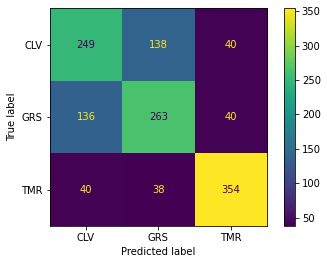

----- Interval: 0 - 172 -----
Accuracy: 0.8420647149460708


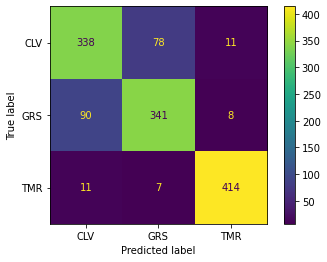

----- Interval: 206 - 536 -----
Accuracy: 0.7650231124807396


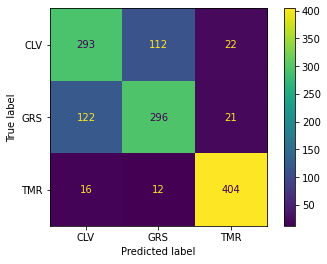

----- Interval: 729 - 748 -----
Accuracy: 0.3574730354391371


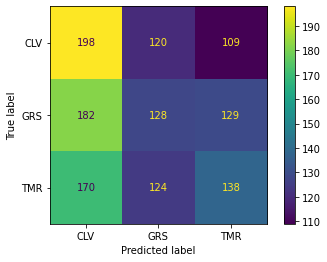

----- Intervals: 0-172 206-536 -----
Accuracy: 0.8343605546995377


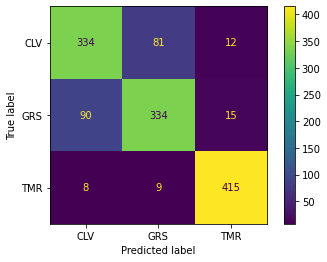

----- No Water -----
Accuracy: 0.8289676425269645


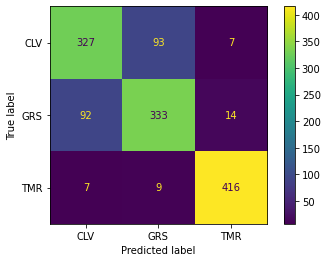

In [5]:
single_split_experiment(clf,X,Y)

In [6]:
cross_validate_experiment(clf, X, Y, cv=3)

----- Whole Series -----
CV Mean Accuracy=3: 0.6565923590295151
----- Interval: 0 - 172 -----
CV Mean Accuracy=3: 0.8326140249181658
----- Interval: 206 - 536 -----
CV Mean Accuracy=3: 0.7586292785883771
----- Interval: 729 - 748 -----
CV Mean Accuracy=3: 0.34988312663190957
----- Intervals: 0-172 206-536 -----
CV Mean Accuracy=3: 0.8409396493399974
----- No Water -----
CV Mean Accuracy=3: 0.840939079365025


## Hyperparameter Tuning

In [8]:
clf = Pipeline(
            [
            #('rfe', RFE(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10)), n_features_to_select=400, step=10)),
            #('feature_selection', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))),
            ('bespoke', RandomPolynomialTransformer(keep_origin=True)),            
                
            #('normalizer', RocketNormalizer()),
            ('normalizer', StandardScaler()),
            #('rfe', RFE(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10)), n_features_to_select=5000, step=100)),
            #('feature_selection2', SelectFromModel(RidgeClassifierCV(alphas=np.logspace(-5, 5, 10)))),
            ('constantfilter',VarianceThreshold()),
            ('selectkbest',SelectKBest(f_classif)),
            #('model', RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True))           
            ('model', LinearDiscriminantAnalysis())           
            ],
            verbose=False,
        )


parameters = {'bespoke__num_kernels':[15000, 16000, 17000, 18000, 19000, 20000],
              'selectkbest__k':[5000, 6000, 7000, 8000, 9000, 10000]}    
gs2 = GridSearchCV(clf, parameters,cv=3,verbose=3)
gs2.fit(X[:, np.r_[0:172, 206:306]],Y)
print(gs2.best_estimator_)
print(gs2.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END bespoke__num_kernels=15000, selectkbest__k=5000;, score=0.855 total time=  10.3s
[CV 2/3] END bespoke__num_kernels=15000, selectkbest__k=5000;, score=0.871 total time=  13.1s
[CV 3/3] END bespoke__num_kernels=15000, selectkbest__k=5000;, score=0.858 total time=  11.5s
[CV 1/3] END bespoke__num_kernels=15000, selectkbest__k=6000;, score=0.859 total time=  11.0s
[CV 2/3] END bespoke__num_kernels=15000, selectkbest__k=6000;, score=0.860 total time=  11.3s
[CV 3/3] END bespoke__num_kernels=15000, selectkbest__k=6000;, score=0.857 total time=  11.1s
[CV 1/3] END bespoke__num_kernels=15000, selectkbest__k=7000;, score=0.848 total time=  12.0s
[CV 2/3] END bespoke__num_kernels=15000, selectkbest__k=7000;, score=0.869 total time=  11.9s
[CV 3/3] END bespoke__num_kernels=15000, selectkbest__k=7000;, score=0.860 total time=  12.0s
[CV 1/3] END bespoke__num_kernels=15000, selectkbest__k=8000;, score=0.850 total time=  12.6

[CV 1/3] END bespoke__num_kernels=19000, selectkbest__k=10000;, score=0.846 total time=  15.7s
[CV 2/3] END bespoke__num_kernels=19000, selectkbest__k=10000;, score=0.866 total time=  16.2s
[CV 3/3] END bespoke__num_kernels=19000, selectkbest__k=10000;, score=0.863 total time=  14.8s
[CV 1/3] END bespoke__num_kernels=20000, selectkbest__k=5000;, score=0.862 total time=  11.5s
[CV 2/3] END bespoke__num_kernels=20000, selectkbest__k=5000;, score=0.870 total time=  12.0s
[CV 3/3] END bespoke__num_kernels=20000, selectkbest__k=5000;, score=0.857 total time=  13.8s
[CV 1/3] END bespoke__num_kernels=20000, selectkbest__k=6000;, score=0.856 total time=  16.4s
[CV 2/3] END bespoke__num_kernels=20000, selectkbest__k=6000;, score=0.867 total time=  13.7s
[CV 3/3] END bespoke__num_kernels=20000, selectkbest__k=6000;, score=0.849 total time=  13.8s
[CV 1/3] END bespoke__num_kernels=20000, selectkbest__k=7000;, score=0.853 total time=  13.5s
[CV 2/3] END bespoke__num_kernels=20000, selectkbest__k=7

## Prediction on Test Data

In [9]:
clf = Pipeline(
            [('bespoke',
                 RandomPolynomialTransformer(keep_origin=True, num_kernels=17000)),
                ('normalizer', StandardScaler()),
                ('constantfilter', VarianceThreshold()),
                ('selectkbest', SelectKBest(k=7000)),
                ('model', LinearDiscriminantAnalysis())],
            verbose=False,
        )

X_real_test = df_dict["Test"][df_dict["Test"]['col1'] >= 1].values
clf.fit(X[:, np.r_[0:172, 206:306]],Y)
y_pred = clf.predict(X_real_test[:, np.r_[0:172, 206:306]])

In [11]:
counts = np.unique(y_pred, return_counts=True)
pd.DataFrame({"Class": counts[0],"Count":counts[1],"Percentage":counts[1]/np.sum(counts[1])})

,Class,Count,Percentage
0,CLV,372,0.345404
1,GRS,366,0.339833
2,TMR,339,0.314763
